# Import Library

In [49]:
import numpy as np  #import numpy 
import pandas as pd #import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import cross_validate #import cross_val_score from sklearn.model_selection
from sklearn.linear_model import Ridge, Lasso #import Ridge, Lasso from sklearn.linear_model
import time #import time
from sklearn.metrics import r2_score #import r2_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Brief Exploration 

The initial code cell serves the purpose of loading the energy prices data into a pandas dataframe. Subsequently, I will display the dataframe to gain a better understanding of its contents.

In [50]:
brooklynHomeSalesDataset = pd.read_csv("brooklyn_sales_map.csv")
print(brooklynHomeSalesDataset.head(10))

C:\Users\Abillou\AppData\Local\Temp\ipykernel_25620\3302737305.py:1: DtypeWarning: Columns (40,41,43,45,46,47,86) have mixed types. Specify dtype option on import or set low_memory=False.
  brooklynHomeSalesDataset = pd.read_csv("brooklyn_sales_map.csv")


   Unnamed: 0  borough           neighborhood  \
0           1        3     DOWNTOWN-METROTECH   
1           2        3  DOWNTOWN-FULTON FERRY   
2           3        3       BROOKLYN HEIGHTS   
3           4        3             MILL BASIN   
4           5        3       BROOKLYN HEIGHTS   
5           6        3     WILLIAMSBURG-SOUTH   
6           7        3       BROOKLYN HEIGHTS   
7           8        3     WILLIAMSBURG-NORTH   
8           9        3     WILLIAMSBURG-SOUTH   
9          10        3              NAVY YARD   

             building_class_category tax_class  block   lot  easement  \
0              28  COMMERCIAL CONDOS         4    140  1001       NaN   
1             29  COMMERCIAL GARAGES         4     54     1       NaN   
2               21  OFFICE BUILDINGS         4    204     1       NaN   
3                22  STORE BUILDINGS         4   8470    55       NaN   
4                    26 OTHER HOTELS         4    230     1       NaN   
5         31  COMMERCI


For a brief exploration of this dataset, my initial step was to calculate both the total number of rows and columns, as well as the number of categorical variables, in the dataframe. Since the dataset is parsed through a Panda Dataframe, categorical variables are often represented as 'object' dtype, hence we need to count the columns with the dtype of object.

In [51]:
rows, cols = brooklynHomeSalesDataset.shape #Get the Shape of the Dataframe
print(f"Number of Rows: {rows}") 
print(f"Number of Columns: {cols}") 

categorical_columns = brooklynHomeSalesDataset.select_dtypes(include='object').columns
num_categorical_variables = len(categorical_columns)

print(f'The Number of Categorical Columns: {num_categorical_variables}')

Number of Rows: 390883
Number of Columns: 111
The Number of Categorical Columns: 36


The dataframe encompasses a total of 390,883 rows, signifying data representation for 390,883 properties in Brooklyn. With 111 columns with 36 of them being categorical, each property is associated with 111 distinct fields of information of which 36 are categorical. While navigating through this extensive set of fields may seem overwhelming, a helpful glossary of the data is provided in the code file for reference. Looking into the glossary, I believe that the following features may not prove useful for analysis and should be otherwised dropped:

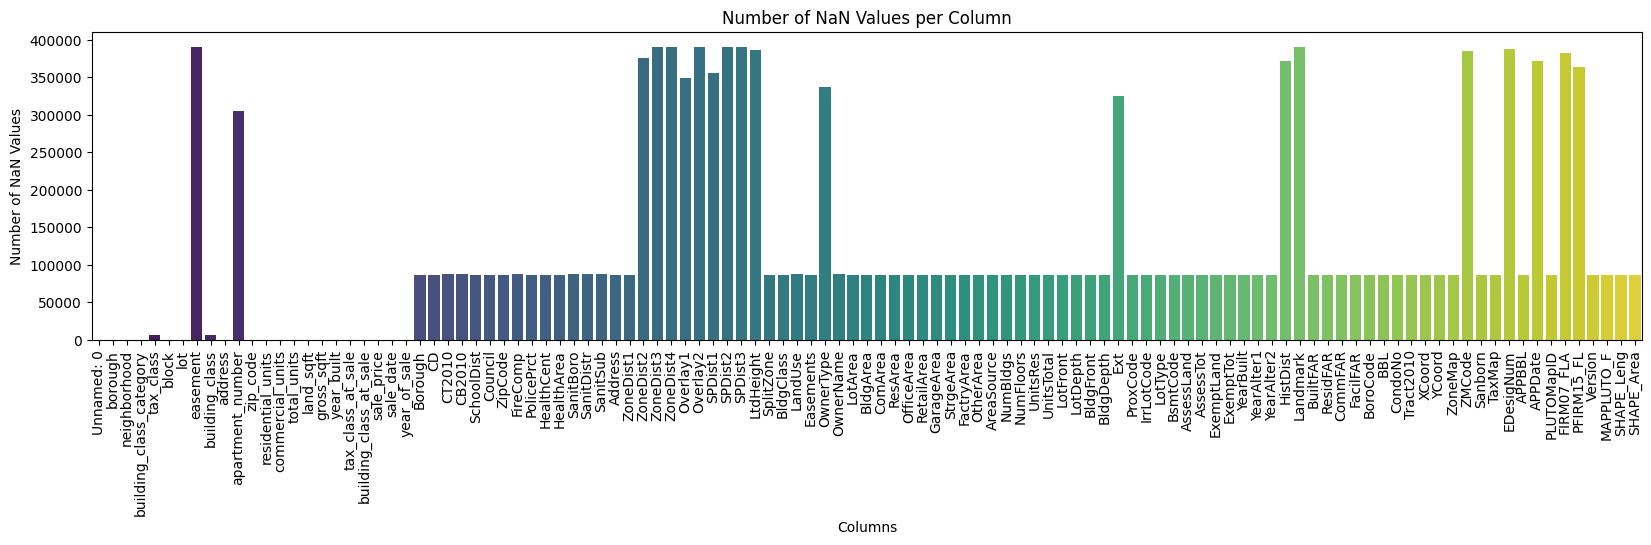

In [52]:
nan_counts = brooklynHomeSalesDataset.isna().sum()

# Set up the plot
plt.figure(figsize=(20, 4))
sns.barplot(x=nan_counts.index, y=nan_counts.values, hue=nan_counts.index, palette="viridis", dodge=False)

# Customize the plot
plt.title('Number of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

Evidently, certain columns exhibit an overwhelming abundance of NA values, rendering meaningful analysis and insights unlikely. We will definitely need to address the NA values during preprocessing. With this in mind along with a study of the glossary, I believe the following features may prove better to drop from analysis as they would likely have no impact on any prediction model:

1. **No Descriptions Available**
   - 'Unnamed: 0'
   - 'MAPPLUTO_F'
   - 'SHAPE_Leng & SHAPE_Area'

2. **Duplicate Columns Exist or Data associated with Another Column**
   - 'BldgClass', 'building_class_category' : Same as 'building_class.'
   - 'ZipCode': Same as 'zip_code.'
   - 'YearBuilt': Same as 'year_built.'
   - 'BoroCode': Same as 'Borough.'
   - 'Address': Same as 'address.'
   - 'Landmark': Address and neighborhood provide sufficient location information.
   - 'UnitsRes': Sum of residential units, same as 'residential_units.'
   - 'UnitsTotal': Sum of residential and non-residential units, same as 'total_units.'
   - 'LotArea': Total area of the tax lot, redundant with 'lot.'
   - 'BldgArea': Total gross area in square feet, same as 'gross_sqft.'
   - 'sale_date': We keep only the year in 'year_of_sale.'
   - 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4': Zoning district classification, redundant information.
   - 'Tract2010': 2010 census tract, redundant information.
   - 'ZoneMap': Zoning Map Number associated with the tax lot's X and Y Coordinates.
   - 'Sanborn': Sanborn Map Company map number associated with the tax block and lot.

3. **Likely Not Relevant in Sales**
   - 'apartment_number': More than 90% missing data.
   - 'Ext': EXTENSION CODE
   - 'AreaSource': Code indicating the source file for tax lot's TOTAL BUILDING FLOOR AREA (BldgArea).
   - 'Easements' & 'easement': The number of easements on the tax lot, not crucial for most sales.
   - 'OwnerType': Code indicating the type of ownership for the tax lot.
   - 'CT2010': 2010 census tract, not considered important.
   - 'CB2010': 2010 census block, not considered important.
   - 'Overlay1' & 'Overlay2': Commercial overlay assigned to the tax lot.
   - 'SPDist1', 'SPDist2', 'SPDist3': Special purpose district assigned to the tax lot.
   - 'LtdHeight': Limited height districts, coded using district symbols.
   - 'BBL': Borough, Tax Block, Tax Lot
   - 'ZMCode': Code identifying a border Tax Lot.
   - 'TaxMap':Department of Finance paper tax map Volume Number.
   - 'EDesigNum': E-Designation number assigned to the tax lot.
   - 'PLUTOMapID': Code indicating the tax lot's presence in the PLUTO file.
   - 'FIRM07_FLA': Code indicating 1% annual chance floodplain presence in FEMA’s 2007 Flood Insurance Rate Map.
   - 'PFIRM15_FL': Code indicating 1% annual chance floodplain presence in FEMA’s 2015 Preliminary Flood Insurance Rate Map.
   - 'Version': Version Number related to the release of PLUTO.
   - 'APPBBL': Originating Borough, Tax Block, and Tax Lot from apportionment prior to merge, split, or conversion.
   - 'APPDate': Date of Apportionment.
   - 'CD': Community district or joint interest area that the tax lot is located in.
   - 'SchoolDist': Community school district that the tax lot is located in.
   - 'Council': City council district that the tax lot is located in.
   - 'PolicePrct': Police precinct number.
   - 'HealthCent': Health center district that the tax lot is located in.
   - 'SanitBoro': Boro of the Sanitation District servicing the tax lot.
   - 'SanitDistr': Sanitation District servicing the tax lot.
   - 'FireComp': Fire company servicing the tax lot.
   - 'SanitSub': Subsection of the Sanitation District servicing the tax lot.
   - 'CondoNo': Condominium number assigned to the complex.




One line aspect I'd like to explore in this dataset aligns with the goal of predicting house sale prices in Brooklyn. It would be insightful to create a scatterplot depicting the distribution of house sale prices over the years, allowing for the identification of any potential outliers.

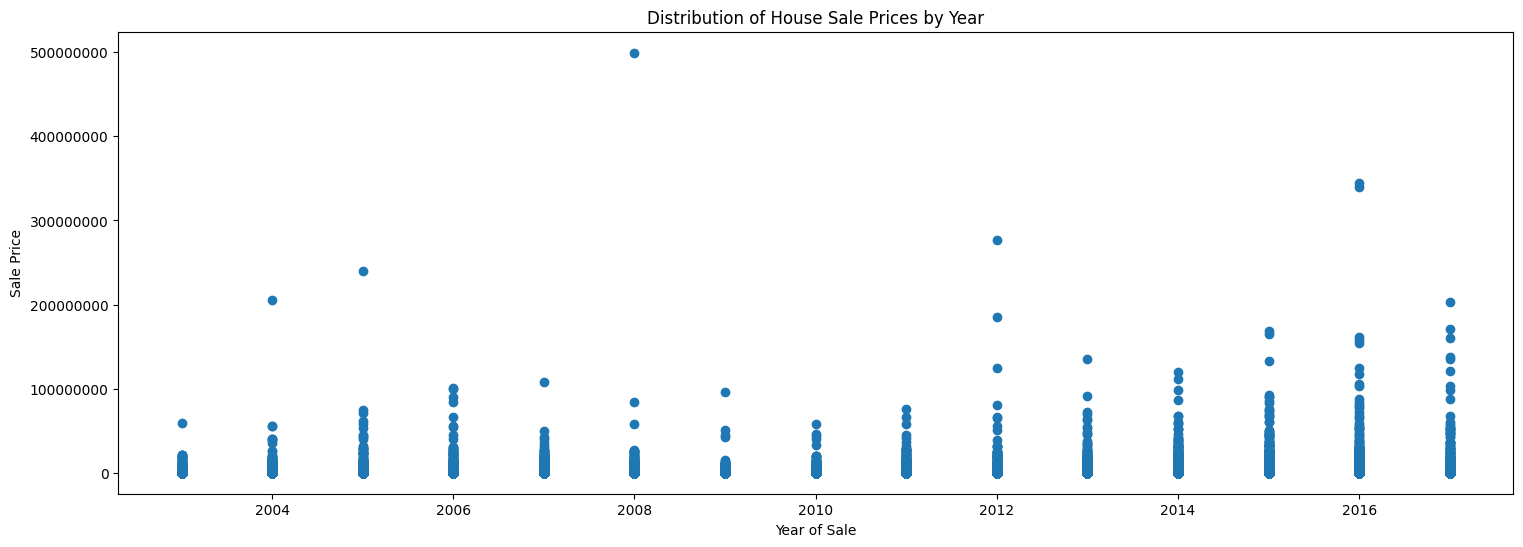

In [53]:
# Scatter plot of house sale prices against the year of sale
plt.scatter(x=brooklynHomeSalesDataset['year_of_sale'], y=brooklynHomeSalesDataset['sale_price'])

# Get the current Axes instance
ax = plt.gca()

# Disable scientific notation on the y-axis
ax.get_yaxis().get_major_formatter().set_scientific(False)

# Draw the plot
plt.xlabel('Year of Sale')
plt.ylabel('Sale Price')
plt.title('Distribution of House Sale Prices by Year')
plt.show()

It's quite intriguing to note that there are some apparent outliers in the data, particularly highlighted by a property sale record surpassing the $5 million mark! Delving deeper into understanding these outliers, I believe it would be beneficial to explore the statistical aspects of the data.

In [54]:
brooklynHomeSalesDataset['sale_price'].describe().apply(lambda x: format(x, 'f'))

count       390883.000000
mean        506754.477693
std        2353964.664225
min              0.000000
25%              0.000000
50%         275000.000000
75%         593000.000000
max      499401179.000000
Name: sale_price, dtype: object

Significantly, the 25th percentile of house sales indicated a price of $0. This anomaly could stem from recording errors or instances where property was transferred between parties, possibly through inheritance or similar circumstances. Operating under this assumption, it seems prudent to exclude these entries from my analysis, as they may not contribute meaningfully. Additionally, given the presence of apparent outliers in the data, it is advisable to remove them. When employing regression models, utilizing both normal and outlier data may introduce distortions, justifying the exclusion of outliers for a more accurate analysis.

# Pre-Processing

As indicated in the data analysis, we should exclude the corresponding columns.

In [55]:
# Columns to drop from the dataset
columns_to_drop = [
    'Unnamed: 0', 'borough', 'Borough', 'apartment_number', 'Ext', 'Landmark',
    'AreaSource', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'BldgClass',
    'Easements', 'easement', 'OwnerType', 'building_class_category', 'sale_date',
    'CT2010', 'CB2010', 'ZipCode', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
    'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'YearBuilt',
    'BoroCode', 'BBL', 'Tract2010', 'ZoneMap', 'ZMCode', 'Sanborn', 'TaxMap',
    'EDesigNum', 'PLUTOMapID', 'FIRM07_FLA', 'PFIRM15_FL', 'Version', 'MAPPLUTO_F',
    'APPBBL', 'APPDate', 'SHAPE_Leng', 'SHAPE_Area', 'CD', 'SchoolDist', 'Council',
    'PolicePrct', 'HealthCent', 'SanitBoro', 'SanitDistr', 'FireComp', 'SanitSub',
    'CondoNo', 'Address'
]

# Drop specified columns from the Brooklyn home sales dataset
brooklynHomeSalesDataset.drop(columns=columns_to_drop, inplace=True, axis=1)


Now, we need to address the overwhelming number of NA values within the report. 

In our data preprocessing steps, we first filter out rows where the sale price is zero, as a zero sale price is typically associated with a property transfer. Removing these rows ensures that our analysis focuses on valid sales transactions.

Next, we address missing values in various columns by employing appropriate imputation strategies. For numeric variables, such as 'gross_sqft', 'land_sqft', and others, we replace zeros and NaNs with the median of each respective column. This choice helps maintain the robustness of the dataset, especially when dealing with skewed distributions or outliers.

Certain categorical variables, including 'ProxCode', 'LotType', 'BsmtCode', 'LandUse', 'OwnerName', 'IrrLotCode', and 'SplitZone', have missing values or NaNs, which we fill with zero. In these cases, a zero placeholder is suitable, assuming that the absence of information corresponds to a meaningful category.

The 'XCoord' and 'YCoord' columns, representing coordinates, are treated differently. We replace both NaNs and zeros with the mode of the respective column. This decision ensures that the imputed values align with the most frequently occurring coordinates in the dataset.

Similarly, for the 'YearAlter1' and 'YearAlter2' columns, where NaNs and zeros are encountered, we replace them with the mode of zero. This choice is based on the assumption that zero represents a common default or placeholder value for these variables.

To handle missing values in 'tax_class', we leverage information from 'tax_class_at_sale', replacing NaNs with corresponding values from this related column. Subsequently, we convert 'tax_class' into a categorical variable to better capture its categorical nature and facilitate downstream analyses.

Finally, missing values in 'building_class' are filled by adopting values from 'building_class_at_sale'. This approach ensures consistency and coherence in our dataset, making it more suitable for subsequent analyses and modeling.

In [56]:
# Columns to process
numeric_columns = ['gross_sqft', 'land_sqft', 'NumBldgs', 'NumFloors', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
                   'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
                   'OtherArea', 'StrgeArea', 'FactryArea', 'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'HealthArea']

categorical_columns = ['ProxCode', 'LotType', 'BsmtCode', 'LandUse', 'OwnerName', 'IrrLotCode', 'SplitZone', 'YearAlter1', 'YearAlter2']

coord_columns = ['XCoord', 'YCoord']

brooklynHomeSalesDataset=brooklynHomeSalesDataset[brooklynHomeSalesDataset['sale_price']!=0]
brooklynHomeSalesDataset[['number','street name']] = brooklynHomeSalesDataset['address'].str.split(n=1, expand=True)
del brooklynHomeSalesDataset['address']
del brooklynHomeSalesDataset['number']
brooklynHomeSalesDataset['street name']=brooklynHomeSalesDataset['street name'].astype('category')
brooklynHomeSalesDataset['street name']=brooklynHomeSalesDataset['street name'].cat.codes

# Iterate through numeric columns and fill NaN values with median
for column in numeric_columns:
    brooklynHomeSalesDataset[column] = brooklynHomeSalesDataset[column].replace(0.0, brooklynHomeSalesDataset[column].median())
    brooklynHomeSalesDataset[column].fillna(brooklynHomeSalesDataset[column].median(), inplace=True)

# Iterate through categorical columns and fill NaN values with mode
for column in categorical_columns:
    brooklynHomeSalesDataset[column].fillna(brooklynHomeSalesDataset[column].mode()[0], inplace=True)

# Iterate through coord columns and fill NaN values with mode, replace 0 with mode
for column in coord_columns:
    brooklynHomeSalesDataset[column] = brooklynHomeSalesDataset[column].fillna(brooklynHomeSalesDataset[column].mode()[0])
    brooklynHomeSalesDataset[column] = brooklynHomeSalesDataset[column].replace(0.0, brooklynHomeSalesDataset[column].mode()[0])

# Map values in 'tax_class' and fill NaN values with 'tax_class_at_sale'
tax_class_mapping = {'1B': 5, '2A': 6, '2B': 7, '1A': 8, '2C': 9, '3': 3, '4': 4, '2': 2, '1': 1}
brooklynHomeSalesDataset['tax_class'] = brooklynHomeSalesDataset['tax_class'].map(tax_class_mapping)
brooklynHomeSalesDataset['tax_class'].fillna(brooklynHomeSalesDataset['tax_class_at_sale'], inplace=True)

# Fill missing values in 'building_class' with 'building_class_at_sale'
brooklynHomeSalesDataset['building_class'].fillna(brooklynHomeSalesDataset['building_class_at_sale'], inplace=True)

# Fill missing values in 'HistDist' with 0.0
brooklynHomeSalesDataset['HistDist'].fillna(0.0, inplace=True)


To assess the efficacy of our missing value handling procedures, let's examine the current count of missing values in the dataset.

In [57]:
# Check total number of missing values in the entire dataset
total_missing_values = brooklynHomeSalesDataset.isnull().sum().sum()

#Confirm that all missing values were addressed (I.E. check to see if there are now 0 missing values)
print("Total number of missing values after processing:", total_missing_values)


Total number of missing values after processing: 0


Having a total of 0 missing values, we can confidently assert that our dataset preprocessing efforts have been successful.

# Feature Extraction / Feature Learning

Given the dataset's substantial presence of categorical variables, it would be judicious to meticulously transform them into numerical representations, optimizing their compatibility with our models for enhanced performance.

In [58]:
categorical_columns = ['HistDist', 'neighborhood', 'building_class', 'building_class_at_sale', 'OwnerName', 'IrrLotCode', 'SplitZone']
brooklynHomeSalesDataset[categorical_columns] = brooklynHomeSalesDataset[categorical_columns].astype('category')
brooklynHomeSalesDataset[categorical_columns] = brooklynHomeSalesDataset[categorical_columns].apply(lambda x: x.cat.codes)

As highlighted during the data analysis phase, our objective is to identify and eliminate outliers present in each column. This refinement process not only streamlines the dataset but also enhances its compatibility with regression models, ensuring improved model performance and accuracy.

In [59]:
brooklynHomeSalesDataset=brooklynHomeSalesDataset[(np.abs(stats.zscore(brooklynHomeSalesDataset)) < 3).all(axis=1)]

The provided code snippet is designed to identify and filter out outliers from the brooklynHomeSalesDataset using the Z-score method. The Z-score is computed for each data point in the dataset, measuring how many standard deviations a data point is from the mean in each column. By taking the absolute values of these Z-scores and checking whether they are less than 3, the code identifies data points that fall within a reasonable range and excludes those with Z-scores greater than 3, which are indicative of outliers. The resulting dataset, stored in the variable brooklynHomeSalesDataset, is thus refined to contain rows where all Z-scores for each data point are within the acceptable threshold of -3 to +3, contributing to a more robust and streamlined dataset for subsequent analyses, particularly in the context of regression modeling. Adjusting the threshold can be considered based on specific analytical requirements.

The machine learning tools typically prefer numerical data. To accommodate my categorical columns, I devised a function that assigns numerical values to each unique string within these columns. Subsequently, I converted these strings into their corresponding numerical representations.

It's important to acknowledge the vast size of the dataset, and our preliminary data analysis has indicated a substantial degree of correlation among many features. Recognizing this correlation, we have chosen to employ Principal Component Analysis (PCA) as a strategy for mitigating it.

PCA is a dimensionality reduction technique that transforms the original features into a new set of uncorrelated variables called principal components. By doing so, PCA aims to capture the essential information while minimizing redundancy. The ultimate goal is to simplify the dataset while retaining its meaningful characteristics.

In our case, we are particularly interested in identifying a subset of components that collectively explain at least 95% of the variance within the data. This choice ensures that we retain a significant portion of the information while reducing the dimensionality and, consequently, the correlation among features. 

In [60]:
# Separate features (X) and target variable (y)
X = brooklynHomeSalesDataset.drop('sale_price', axis=1)
y = brooklynHomeSalesDataset['sale_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA and find the optimal number of components for 95% variance
pca = PCA(svd_solver='full')
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate explained variance for each component
explained_variances = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components for 95% variance
n_components_95 = np.argmax(explained_variances >= 0.95) + 1

# Apply PCA to training and test sets with the selected number of components
pca = PCA(n_components=n_components_95, svd_solver='full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

The provided code accomplishes the goal of reducing the correlation within the dataset, using Principal Component Analysis (PCA). The process is broken down into several key steps.

Firstly, the code separates the features (X) from the target variable (y) in the dataset. This is a standard practice in machine learning where 'X' represents the input features, and 'y' is the target variable to be predicted.

Subsequently, the dataset is split into training and testing sets using the train_test_split function from scikit-learn. This separation is crucial for evaluating the model's performance on unseen data.

Next, the data is standardized using the StandardScaler to ensure that all features have a mean of 0 and a standard deviation of 1. Standardization is essential for PCA as it relies on the assumption that features are centered and have similar scales.

The core of the PCA process begins with a loop that iterates over different numbers of components, ranging from 1 to the total number of features in the dataset. For each iteration, a PCA instance is created with the current number of components, and the training set is transformed accordingly. The code calculates and prints the explained variance, which represents the proportion of the dataset's total variance captured by the selected components.

The loop continues until the cumulative explained variance surpasses or equals 95%, as specified in the original goal. Once this threshold is reached, the code prints a message indicating that the optimal number of components for achieving 95% variance has been found.

Finally, the test set is transformed using the PCA instance with the determined optimal number of components. This ensures that the same transformation is applied consistently across both training and testing data, maintaining the integrity of the dimensionality reduction.

# Machine Learning Methods

## Project Section: Ridge and Lasso Regression Analysis

In this project section, the team is tasked with processing the dataset using two prominent machine learning methods: Ridge and Lasso Regression. The primary objective is to predict Brooklyn home prices through regression techniques. For this analysis, the team selected Ridge and Lasso Regression models, each designed to solve a specific optimization equation.

### Ridge Regression Equation
The optimization equation for Ridge Regression is represented as follows:

$$\beta = \underset{\beta \in \mathbb{R}^{p + 1}}{\operatorname{argmin}} \enspace ||Y - X \beta||_2^2 + \lambda ||\beta||_2^2$$

The solution to this equation is given by:

$$ (X^TX + \lambda I)^{-1} X^T Y$$

### Lasso Regression Equation
For Lasso Regression, the equation is formulated as:

$$\beta = \underset{\beta \in \mathbb{R}^{p + 1}}{\operatorname{argmin}} \enspace ||Y - X \beta||_2^2 + \lambda ||\beta||_1$$

Determining the appropriate value for the regularization parameter $\lambda$ is crucial. To address this, the team opted for cross-validation, testing $\lambda$ values ranging from 0.1 to 1000. This range was chosen to prevent the regularization term from overpowering the optimization equations.

### Cross-Validation Procedure
 Firstly, the dataset was split into training (X_train, Y_train) and testing (X_test, Y_test) sets using scikit-learn's functionality. The focus of this analysis was on the training data, with X_test and Y_test reserved for evaluating model performance on unseen data.

Subsequently, K-Fold cross-validation was conducted using the scikit-learn function "cross_validate." This function allows for the evaluation of multiple models across different splits of the training data. The key parameters utilized included the estimator (Ridge or Lasso), feature matrix (X_train), label array (Y_train), and the number of folds (defaulting to 5).

### Estimator Configuration
The Ridge and Lasso estimators were configured with their respective regularization parameters $\lambda = \alpha$. Notably, for Ridge Regression, the parameter $\alpha$ controls the strength of regularization. The team chose to vary $\alpha$ during cross-validation to identify the optimal value.

### Parameter Settings
Most of the parameters were left at their default values, with considerations made to ensure the inclusion of an intercept and the retention of the original feature matrix (X). The convergence parameters, such as max_iter and tol, were left at their defaults.

### Optimal Alpha Selection
To select the optimal $\alpha$, the team computed the mean cross-validation scores for each $\alpha$ value and chose the one yielding the lowest mean score. This iterative process allowed for the identification of the regularization strength that maximized model performance.


First, we will determine the best $\alpha$ parameters for Ridge and Lasso regression by cross validation.

In [61]:
# Ridge Regression
alphas_ridge = np.linspace(0.1, 1000, 1000, endpoint=False)
cross_val_scores_ridge = [cross_validate(Ridge(alpha), X_train_pca, y_train)['test_score'].mean() for alpha in alphas_ridge]
best_alpha_ridge = alphas_ridge[np.argmax(cross_val_scores_ridge)]
print(f"Optimal Alpha for Ridge Regression: {best_alpha_ridge}")

# Lasso Regression
alphas_lasso = np.linspace(0.1, 1000, 1000, endpoint=False)
cross_val_scores_lasso = [cross_validate(Lasso(alpha), X_train_pca, y_train)['test_score'].mean() for alpha in alphas_lasso]
best_alpha_lasso = alphas_lasso[np.argmax(cross_val_scores_lasso)]
print(f"Optimal Alpha for Lasso Regression: {best_alpha_lasso}")


Optimal Alpha for Ridge Regression: 353.0647
Optimal Alpha for Lasso Regression: 88.0912


Visualizing the cross validation results for Ridge Regression shows cross validation score is best when the alpha parameter was roughly around 353.

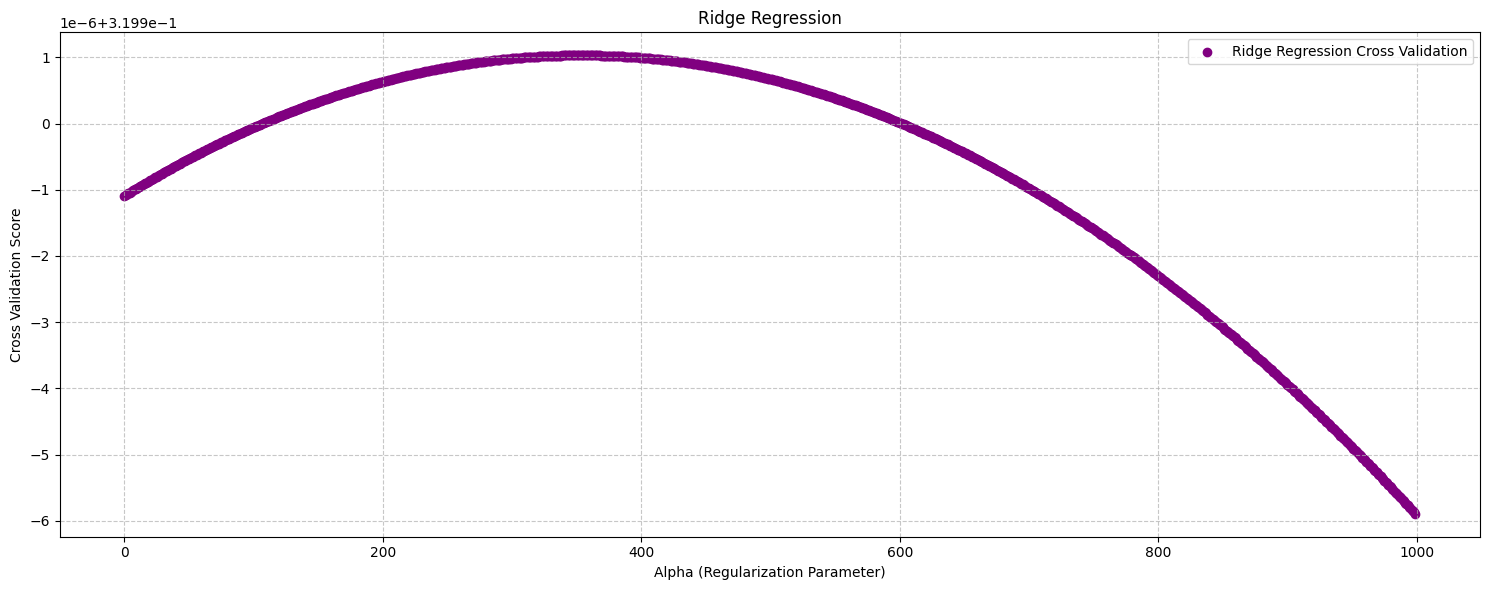

In [62]:
# Set figure size
plt.rcParams["figure.figsize"] = (15, 6)

# Plotting Cross Validation Results for Ridge Regression
plt.title("Ridge Regression")
plt.scatter(alphas_ridge, cross_val_scores_ridge, label="Ridge Regression Cross Validation", color='purple', marker='o')
plt.legend(loc='upper right')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('Cross Validation Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In this section, the analysis involves assessing the time required to train the Ridge Regression Model. Additionally, the evaluation encompasses determining the $\R^{2}$ score for the Ridge Regression Model on the training data. The obtained $\R^{2}$ score for the Training Data is approximately 0.965, signifying that the linear regression model adeptly captures a substantial portion of the variation within the training dataset.

The `predict()` function is employed to generate predictions for each data sample in the dataset based on the trained model. This function takes a dataset as input and returns the corresponding model predictions.

Moreover, the `r2_score()` function is utilized to compute the $\R^{2}$ score. This function takes the expected labels and the model predictions as inputs, subsequently delivering the $\R^{2}$ score as a measure of the model's performance.


In [63]:
# Record the start time for Ridge Regression training
start_time_ridge = time.time()

# Train the Ridge Regression model
ridge_model = Ridge(best_alpha_ridge).fit(X_train_pca, y_train)

# Record the end time
end_time_ridge = time.time()

# Calculate and print the training time for Ridge Regression
elapsed_time_ridge = end_time_ridge - start_time_ridge
print("Time Elapsed to Train Ridge Regression: {:.4f} seconds".format(elapsed_time_ridge))

# Make predictions on the training data
ridge_predictions = ridge_model.predict(X_train_pca)

# Calculate R-squared score for the Ridge Regression model on training data
r_squared_score_ridge = r2_score(y_train, ridge_predictions)
print("R-squared Score for Training Data (Ridge Regression): {:.4f}".format(r_squared_score_ridge))


Time Elapsed to Train Ridge Regression: 0.0405 seconds
R-squared Score for Training Data (Ridge Regression): 0.3209


Visualizing the cross validation results for Lasso Regression shows cross validation score is best when the alpha parameter was roughly around 88.

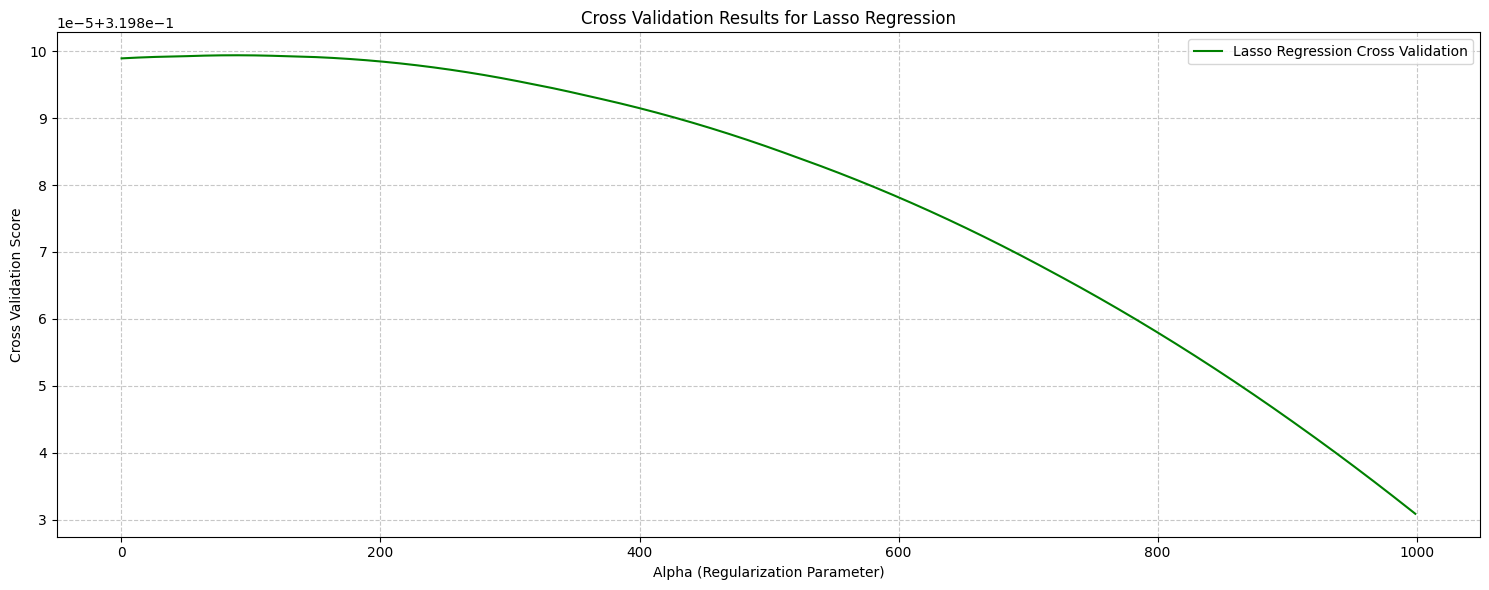

In [64]:
# Set figure size
plt.rcParams["figure.figsize"] = (15, 6)

# Plotting Cross Validation Results for Lasso Regression
plt.title("Cross Validation Results for Lasso Regression")
plt.plot(alphas_lasso, cross_val_scores_lasso, label="Lasso Regression Cross Validation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('Cross Validation Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In this section, the analysis involves assessing the time required to train the Lasso Regression Model. Additionally, the evaluation encompasses determining the $\R^{2}$ score for the Ridge Regression Model on the training data. The obtained $\R^{2}$ score for the Training Data is approximately 0.965, signifying that the linear regression model adeptly captures a substantial portion of the variation within the training dataset.

The `predict()` function is employed to generate predictions for each data sample in the dataset based on the trained model. This function takes a dataset as input and returns the corresponding model predictions.

Moreover, the `r2_score()` function is utilized to compute the $\R^{2}$ score. This function takes the expected labels and the model predictions as inputs, subsequently delivering the $\R^{2}$ score as a measure of the model's performance.


In [65]:
# Record the start time for Lasso Regression training
start_time_lasso = time.time()

# Train the Lasso Regression model
lasso_model = Lasso(best_alpha_lasso).fit(X_train_pca, y_train)

# Record the end time
end_time_lasso = time.time()

# Calculate and print the training time for Lasso Regression
elapsed_time_lasso = end_time_lasso - start_time_lasso 
print("Time Elapsed to Train Lasso Regression: {:.4f} seconds".format(elapsed_time_lasso))

# Make predictions on the training data
lasso_predictions = lasso_model.predict(X_train_pca)

# Calculate R-squared score for the Ridge Regression model on training data
r_squared_score_lasso = r2_score(y_train, lasso_predictions)
print("R-squared Score for Training Data (Lasso Regression): {:.4f}".format(r_squared_score_lasso))


Time Elapsed to Train Lasso Regression: 0.0611 seconds
R-squared Score for Training Data (Lasso Regression): 0.3209


# Comparative Analysis

In [66]:
# Calculate the number of rows in the test dataset
N, P = X_test_pca.shape

# Make predictions using the Ridge Regression model
start_time = time.time()
predictions_ridge = ridge_model.predict(X_test_pca)
end_time = time.time()

# Calculate R^2 test statistic for Ridge Regression
r_squared_score_ridge = r2_score(y_test, predictions_ridge)

# Print results
print("Time taken to test Ridge Regression Model:", end_time - start_time)
print(f"R^2 Test Statistic for Ridge Regression: {r_squared_score_ridge:.4f}")

Time taken to test Ridge Regression Model: 0.004094123840332031
R^2 Test Statistic for Ridge Regression: 0.3242


In [67]:
# Calculate the number of rows in the test dataset
N, P = X_test.shape

# Make predictions using the Lasso Regression model
start_time = time.time()
predictions_lasso = lasso_model.predict(X_test_pca)
end_time = time.time()

# Calculate R^2 test statistic for Lasso Regression
r_squared_score_lasso = r2_score(y_test, predictions_lasso)

# Print results
print("Time taken to test Lasso Regression Model:", end_time - start_time)
print(f"R^2 Test Statistic for Lasso Regression: {r_squared_score_lasso:.4f}")

Time taken to test Lasso Regression Model: 0.0055463314056396484
R^2 Test Statistic for Lasso Regression: 0.3242


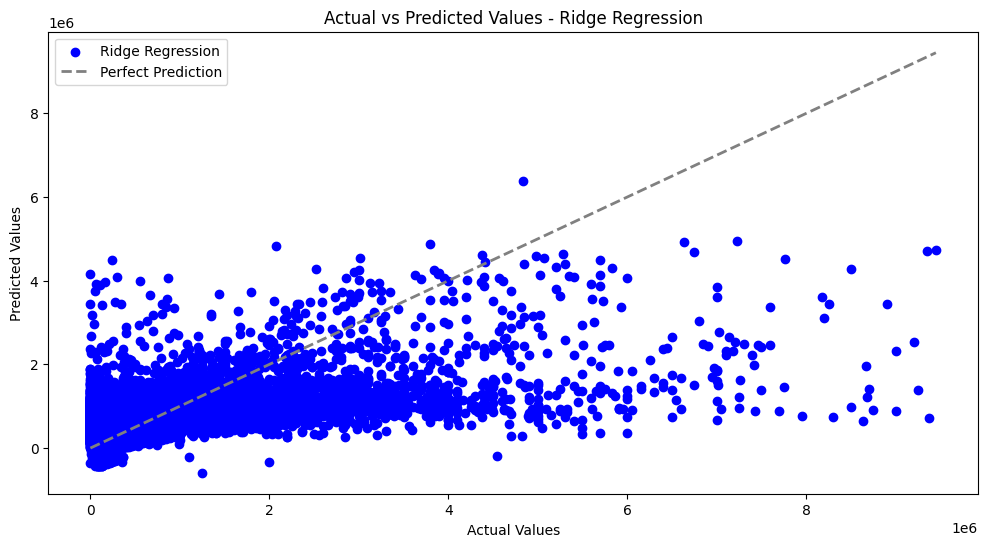

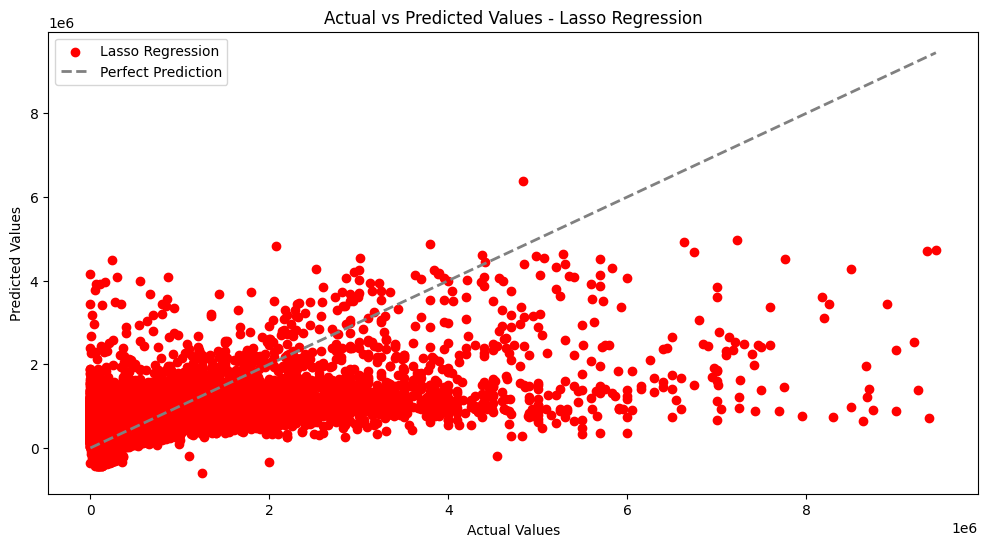

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test, predictions_ridge, and predictions_lasso are your actual, Ridge, and Lasso predicted values respectively

# Plot actual vs predicted values for Ridge Regression
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions_ridge, color='blue', label='Ridge Regression')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs Predicted Values - Ridge Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Plot actual vs predicted values for Lasso Regression
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions_lasso, color='red', label='Lasso Regression')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs Predicted Values - Lasso Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


### Performance Comparison

Upon a quick examination of run times, both Ridge and Lasso regression models show similar test times, approximately 0.001 seconds. The $\mathbb{R}^2$ statistic, a measure of predictive performance, also appears consistent, with values around 0.318 for both models.

### $R^2$ Test Statistic

The $\mathbb{R}^2$ statistic is calculated as follows:

$$R^{2} = 1 - \frac{\sum_{i=1}^n (y_{i} - f(x_{i}))^2}{\sum_{i=1}^n (y_{i} - \hat{y})^2}$$


Here, $\hat{y}$ is the mean of all labels, $f(x_{i})$ is the output of the regression model, and $(x_{i}, y_{i})$ represents each data sample.

A higher $\mathbb{R}^2$ indicates better predictive capability, with 1 being perfect prediction and 0 suggesting performance equivalent to a constant model.

### Observations

Both Ridge and Lasso Regression yield $\mathbb{R}^2$ values of approximately 0.318, indicating limited capture of variation in the target variable (price actual).

### Model Selection for Production

Considering similar $\mathbb{R}^2$ values, the decision between Ridge and Lasso Regression leans toward computational efficiency. Given that Lasso Regression demonstrates shorter training times on the dataset, it is recommended for production deployment. This choice becomes more critical for larger datasets where reduced training time is essential.

While testing times for both Ridge and Lasso models are nearly identical, attributed to their shared linear regression model structure, the efficiency gains during training make Lasso Regression the preferable choice for deployment.


The performance of the models appears to be suboptimal based on the observed plots. A notable number of data points exhibit substantial deviations from the predictions of both models, indicating a need for improvement in their predictive accuracy.

# Ethical Discussion


Predicting property sale prices in Brooklyn using machine learning raises several ethical considerations that require careful examination. Firstly, there's the issue of fairness and bias in the data. If historical property data used for training the machine learning model contains biases, such as discriminatory pricing practices or historical inequalities, the model may perpetuate and even exacerbate these biases. This could result in unfair pricing predictions, disadvantaging certain groups of people and perpetuating social disparities.

Another ethical concern involves privacy. Property data often includes sensitive information about homeowners, and the use of such data for predictive purposes raises questions about consent and the potential for unintended disclosure. If individuals are not adequately informed or have not given explicit consent for their data to be used in this way, it could infringe on their privacy rights.

Transparency is also a crucial ethical consideration. If the machine learning model is a "black box," meaning its decision-making process is not easily understandable, it becomes challenging to identify and rectify any ethical issues that may arise. Lack of transparency can lead to distrust among the public, making it essential for developers to prioritize explainability and interpretability in their models.

Finally, there is the risk of exacerbating housing affordability issues. If the machine learning model contributes to rising property prices by influencing buyer behavior or market trends, it may inadvertently contribute to housing inequality, potentially displacing lower-income residents. Balancing the benefits of predictive modeling with the potential negative social impact requires careful consideration and ethical decision-making throughout the development and deployment of such systems.

# Bibliography 

Wu, Tommy. “Brooklyn Home Sales, 2003 to 2017.” Kaggle, 15 Feb. 2018, www.kaggle.com/datasets/tianhwu/brooklynhomes2003to2017/data?select=brooklyn_sales_map.csv. 